In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# LANGKAH 1: MEMBACA DAN MEMPERSIAPKAN DATA
print("="*60)
print("TRANSFORMASI DATA UNTUK TIME SERIES FORECASTING")
print("="*60)

df = pd.read_excel('Book1.xlsx')

# Bersihkan data
df_clean = df.copy()
df_clean['Bulan'] = df_clean['Bulan'].fillna(method='ffill')
df_clean = df_clean.dropna(subset=['Indikator Perubahan Harga (%)'])

print(f"Data berhasil dibersihkan: {len(df_clean)} observasi")

TRANSFORMASI DATA UNTUK TIME SERIES FORECASTING
Data berhasil dibersihkan: 96 observasi


In [19]:
# LANGKAH 2: BUAT KOLOM TANGGAL DAN URUTAN WAKTU
print("\nLANGKAH 2: MEMBUAT URUTAN WAKTU")
print("="*40)

def ekstrak_tahun(bulan_str):
    if "'24" in str(bulan_str):
        return 2024
    elif "'25" in str(bulan_str):
        return 2025
    else:
        return 2023

def ekstrak_bulan(bulan_str):
    peta_bulan = {
        'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4,
        'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8,
        'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
    }
    for nama_bulan, nomor_bulan in peta_bulan.items():
        if nama_bulan in str(bulan_str):
            return nomor_bulan
    return 1

# Buat kolom waktu
df_clean['Tahun'] = df_clean['Bulan'].apply(ekstrak_tahun)
df_clean['Bulan_Angka'] = df_clean['Bulan'].apply(ekstrak_bulan)
df_clean['Minggu_Angka'] = df_clean['Minggu ke-'].str.extract('(\d+)').astype(int)

# Buat tanggal
df_clean['Tanggal'] = pd.to_datetime(df_clean[['Tahun', 'Bulan_Angka']].rename(columns={'Tahun': 'year', 'Bulan_Angka': 'month'}).assign(day=1)) + pd.to_timedelta((df_clean['Minggu_Angka']-1)*7, unit='D')

# Urutkan berdasarkan tanggal
df_clean = df_clean.sort_values('Tanggal').reset_index(drop=True)

# Buat periode berurutan untuk x-axis
df_clean['Periode'] = range(1, len(df_clean) + 1)

print(f"Periode data: {df_clean['Tanggal'].min()} sampai {df_clean['Tanggal'].max()}")


LANGKAH 2: MEMBUAT URUTAN WAKTU
Periode data: 2023-01-01 00:00:00 sampai 2024-12-22 00:00:00


In [20]:
# LANGKAH 3: SIAPKAN DATA UNTUK FORECASTING
print("\nLANGKAH 3: PERSIAPAN DATA FORECASTING")
print("="*40)

# Dataset untuk forecasting
forecasting_data = df_clean[['Periode', 'Tanggal', 'Bulan', 'Minggu ke-', 'Indikator Perubahan Harga (%)', 'Harga ']].copy()

# Rename kolom
forecasting_data.columns = ['Periode', 'Tanggal', 'Bulan', 'Minggu', 'Indikator_Harga', 'Fluktuasi_Tertinggi']

# Konversi ke numerik
forecasting_data['Indikator_Harga'] = pd.to_numeric(forecasting_data['Indikator_Harga'], errors='coerce')
forecasting_data['Fluktuasi_Tertinggi'] = pd.to_numeric(forecasting_data['Fluktuasi_Tertinggi'], errors='coerce')

print("Dataset forecasting siap:")
print(forecasting_data.head())


LANGKAH 3: PERSIAPAN DATA FORECASTING
Dataset forecasting siap:
   Periode    Tanggal     Bulan Minggu  Indikator_Harga  Fluktuasi_Tertinggi
0        1 2023-01-01   Januari     M1        -1.340000             0.055300
1        2 2023-01-08   Januari     M2         0.934199             0.032991
2        3 2023-02-08  Februari     M2         1.361168             0.034939
3        4 2023-02-15  Februari     M3         1.823811             0.065767
4        5 2023-02-22  Februari     M4         2.179918             0.063383


In [21]:
# LANGKAH 4: TAMBAH FITUR LAG UNTUK FORECASTING
print("\nLANGKAH 4: MENAMBAH FITUR LAG")
print("="*40)

# Tambah lag features
for lag in [1, 2, 3, 4]:
    forecasting_data[f'Lag_{lag}'] = forecasting_data['Indikator_Harga'].shift(lag)

# Tambah moving averages
forecasting_data['MA_3'] = forecasting_data['Indikator_Harga'].rolling(window=3).mean()
forecasting_data['MA_7'] = forecasting_data['Indikator_Harga'].rolling(window=7).mean()

# Hapus missing values
forecasting_data_clean = forecasting_data.dropna()

print(f"Data dengan fitur lag: {len(forecasting_data_clean)} observasi")
print("Fitur yang tersedia:", list(forecasting_data_clean.columns))


LANGKAH 4: MENAMBAH FITUR LAG
Data dengan fitur lag: 86 observasi
Fitur yang tersedia: ['Periode', 'Tanggal', 'Bulan', 'Minggu', 'Indikator_Harga', 'Fluktuasi_Tertinggi', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'MA_3', 'MA_7']



LANGKAH 5: VISUALISASI TIME SERIES


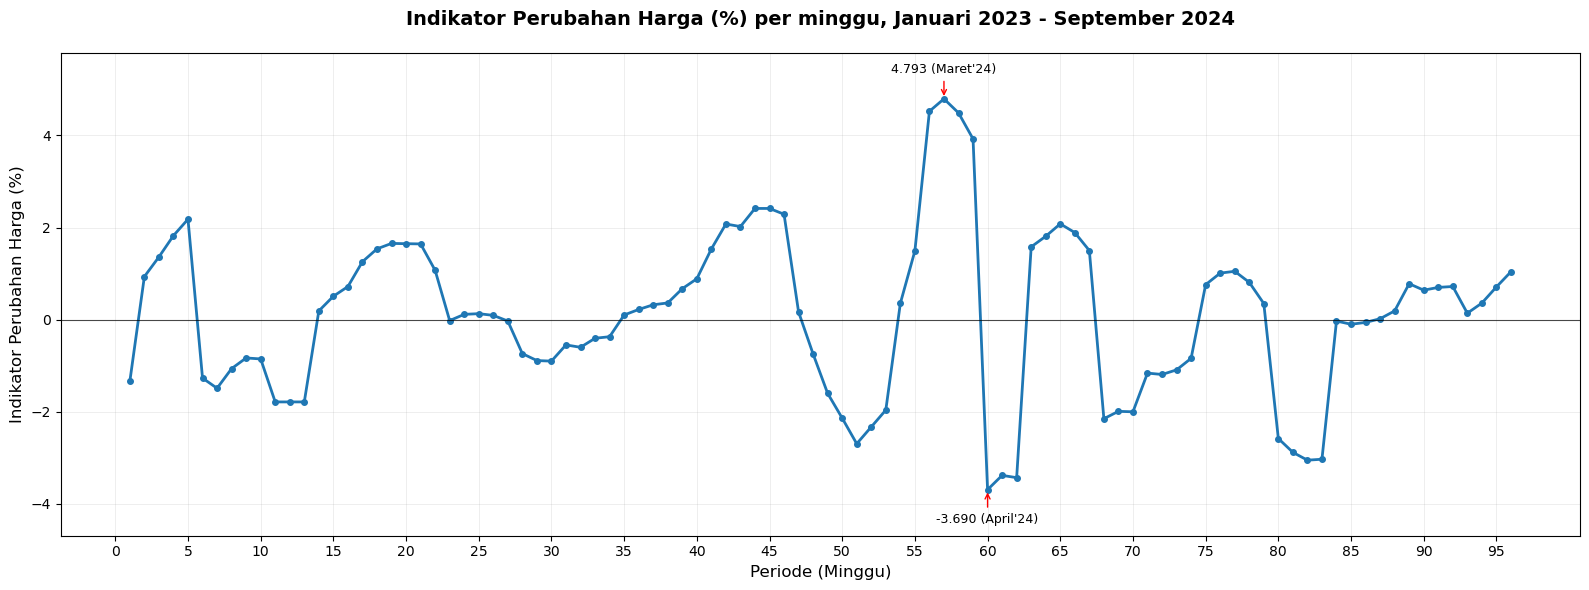

Plot time series disimpan: indikator_perubahan_harga_time_series.png


In [ ]:
# LANGKAH 5: BUAT VISUALISASI SEPERTI DI GAMBAR
print("\nLANGKAH 5: VISUALISASI TIME SERIES")
print("="*40)

# Set style untuk plot yang bagus
plt.style.use('default')
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

# Buat plot seperti di gambar
fig, ax = plt.subplots(figsize=(16, 6))

# Plot garis utama
ax.plot(forecasting_data['Periode'], forecasting_data['Indikator_Harga'], 
        color='#1f77b4', linewidth=2, marker='o', markersize=4)

# Tambahkan grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Set labels dan title
ax.set_title('Indikator Perubahan Harga (%) per minggu, Januari 2023 - September 2024', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Periode (Minggu)', fontsize=12)
ax.set_ylabel('Indikator Perubahan Harga (%)', fontsize=12)

# Set y-axis range
y_min = forecasting_data['Indikator_Harga'].min() - 1
y_max = forecasting_data['Indikator_Harga'].max() + 1
ax.set_ylim(y_min, y_max)

# Tambahkan garis horizontal di y=0
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

# Annotate beberapa titik penting (nilai maksimum dan minimum)
max_idx = forecasting_data['Indikator_Harga'].idxmax()
min_idx = forecasting_data['Indikator_Harga'].idxmin()

max_val = forecasting_data.loc[max_idx, 'Indikator_Harga']
min_val = forecasting_data.loc[min_idx, 'Indikator_Harga']
max_periode = forecasting_data.loc[max_idx, 'Periode']
min_periode = forecasting_data.loc[min_idx, 'Periode']
max_bulan = forecasting_data.loc[max_idx, 'Bulan']
min_bulan = forecasting_data.loc[min_idx, 'Bulan']

# Annotate titik maksimum
ax.annotate(f'{max_val:.3f} ({max_bulan})', 
            xy=(max_periode, max_val), 
            xytext=(max_periode, max_val + 0.5),
            ha='center', va='bottom',
            fontsize=9,
            arrowprops=dict(arrowstyle='->', color='red', lw=1))

# Annotate titik minimum
ax.annotate(f'{min_val:.3f} ({min_bulan})', 
            xy=(min_periode, min_val), 
            xytext=(min_periode, min_val - 0.5),
            ha='center', va='top',
            fontsize=9,
            arrowprops=dict(arrowstyle='->', color='red', lw=1))

# Set x-axis ticks (setiap 5 periode)
x_ticks = range(0, len(forecasting_data), 5)
ax.set_xticks(x_ticks)

# Tight layout
plt.tight_layout()
plt.show()

print("Plot time series disimpan: indikator_perubahan_harga_time_series.png")

In [23]:
# LANGKAH 6: SIMPAN DATA UNTUK FORECASTING
print("\nLANGKAH 6: SIMPAN DATA UNTUK FORECASTING")
print("="*40)

# Simpan dataset lengkap
forecasting_data.to_csv('data_time_series_lengkap.csv', index=False)

# Simpan dataset untuk modeling (tanpa missing values)
forecasting_data_clean.to_csv('data_untuk_forecasting.csv', index=False)

# Buat summary statistik
summary_stats = {
    'Jumlah_Observasi': len(forecasting_data_clean),
    'Periode_Awal': forecasting_data_clean['Tanggal'].min().strftime('%Y-%m-%d'),
    'Periode_Akhir': forecasting_data_clean['Tanggal'].max().strftime('%Y-%m-%d'),
    'Nilai_Minimum': forecasting_data_clean['Indikator_Harga'].min(),
    'Nilai_Maksimum': forecasting_data_clean['Indikator_Harga'].max(),
    'Rata_rata': forecasting_data_clean['Indikator_Harga'].mean(),
    'Standar_Deviasi': forecasting_data_clean['Indikator_Harga'].std()
}

print("\nSUMMARY STATISTIK:")
print("="*30)
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Tampilkan contoh data
print(f"\nCONTOH DATA UNTUK FORECASTING:")
print(forecasting_data_clean[['Periode', 'Tanggal', 'Bulan', 'Indikator_Harga', 'Lag_1', 'MA_3']].head(10))

print(f"\n{'='*60}")
print("TRANSFORMASI SELESAI!")
print("File yang dihasilkan:")
print("1. indikator_perubahan_harga_time_series.png - Visualisasi time series")
print("2. data_time_series_lengkap.csv - Dataset lengkap")
print("3. data_untuk_forecasting.csv - Dataset siap untuk modeling")
print("Dataset siap untuk forecasting dengan ARIMA, LSTM, atau ML models!")
print(f"{'='*60}")


LANGKAH 6: SIMPAN DATA UNTUK FORECASTING

SUMMARY STATISTIK:
Jumlah_Observasi: 86
Periode_Awal: 2023-03-08
Periode_Akhir: 2024-12-22
Nilai_Minimum: -3.6900
Nilai_Maksimum: 4.7931
Rata_rata: 0.0168
Standar_Deviasi: 1.7304

CONTOH DATA UNTUK FORECASTING:
    Periode    Tanggal  Bulan  Indikator_Harga     Lag_1      MA_3
6         7 2023-03-08  Maret        -1.488879 -1.268096 -0.192352
7         8 2023-03-15  Maret        -1.062969 -1.488879 -1.273314
8         9 2023-03-22  Maret        -0.831356 -1.062969 -1.127735
9        10 2023-03-29  Maret        -0.852597 -0.831356 -0.915641
10       11 2023-04-01  April        -1.785644 -0.852597 -1.156532
11       12 2023-04-08  April        -1.785644 -1.785644 -1.474629
12       13 2023-04-22  April        -1.785644 -1.785644 -1.785644
13       14 2023-05-01    Mei         0.189215 -1.785644 -1.127358
14       15 2023-05-08    Mei         0.508090  0.189215 -0.362780
15       16 2023-05-15    Mei         0.718023  0.508090  0.471776

TRANSFOR

In [25]:
print("="*40)

# Split data 80-20 untuk training-testing
split_point = int(0.8 * len(forecasting_data_clean))

train_data = forecasting_data_clean.iloc[:split_point].copy()
test_data = forecasting_data_clean.iloc[split_point:].copy()

print(f"Training data: {len(train_data)} observasi")
print(f"Testing data: {len(test_data)} observasi")

# Simpan data terpisah
train_data.to_csv('data_training.csv', index=False)
test_data.to_csv('data_testing.csv', index=False)

# Contoh untuk forecasting selanjutnya
print(f"\nCONTOH UNTUK FORECASTING PERIODE BERIKUTNYA:")
print("Target variable: 'Indikator_Harga'")
print("Features available: Lag_1, Lag_2, Lag_3, Lag_4, MA_3, MA_7, Fluktuasi_Tertinggi")

print(f"\nData terakhir untuk prediksi:")
print(forecasting_data_clean[['Periode', 'Tanggal', 'Indikator_Harga']].tail())

Training data: 68 observasi
Testing data: 18 observasi

CONTOH UNTUK FORECASTING PERIODE BERIKUTNYA:
Target variable: 'Indikator_Harga'
Features available: Lag_1, Lag_2, Lag_3, Lag_4, MA_3, MA_7, Fluktuasi_Tertinggi

Data terakhir untuk prediksi:
    Periode    Tanggal  Indikator_Harga
91       92 2024-11-22             0.72
92       93 2024-12-01             0.14
93       94 2024-12-08             0.36
94       95 2024-12-15             0.71
95       96 2024-12-22             1.04
